## Ready To Go

In [19]:
#imports
import importlib
import glob
import importlib
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from experiments.models import PD_CNN
import torch
import experiments.training_and_validation as training_and_validation
import experiments.data_handling as data_handling
import experiments.helper_functions as helper_functions
from experiments.training_and_validation import loso_cross_validation, train, validate, cross_train, UNM_train, UNM_validate, UNM_testing_subject
from experiments.training_and_validation import with_leak_validate, testing_epoch_validate, with_leak_train
from experiments.result_visualization import run_chi_squared_test, plot_confusion_matrix, plot_roc_auc, plot_confusion_matrix, make_combo_plot
from experiments.result_visualization import waterfall_plot, sequence_plot, wise_roc_curve, plot_roc_matrix, plot_both
from experiments.helper_functions import load_dataset, data_loader, confirm_model, visualize, name_model, run_replicates, UNM_val, UNM_visualize_1
from experiments.helper_functions import UNM_visualize_2, subject_list, epoch_level_model, testing_epoch_func, testing_epoch_viz, train_test_split
from experiments.helper_functions import CV_leak_visualize, data_loader_val_only
from torch.utils.data import DataLoader, random_split
import experiments.data_handling as data_handling
import experiments.models as models
import experiments.result_visualization as result_visualization

In [18]:
importlib.reload(training_and_validation)
importlib.reload(data_handling)
importlib.reload(helper_functions)
importlib.reload(result_visualization)

<module 'result_visualization' from '/Users/rakan/ResearchPD/DL_for_EEG/result_visualization.py'>

In [3]:
#set the device to cuda:0 
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

## PD CNN Class

In [10]:
'''
This file contains the deep learning models used in the project.
- All models are implemented using PyTorch and are subclasses of nn.Module.
- Note that the model architecture essentially has to be hard-coded so that means for different datatypes, we need to write different models.
for clinical EEG with ~60 channels, we have one architecture and for wearable EEG with 4 channels, we need a new architecture (adapted from the other one).

I've put the existing model for the ~60 channels below, but I haven't formatted or managed the libraries for you. 
'''
import torch.nn as nn
import torch

class PD_CNN(nn.Module):

    def __init__(self,chunk_size=2500):
        super(PD_CNN, self).__init__()
        self.chunk_size = chunk_size

        self.conv1 = nn.Conv1d(in_channels=60, out_channels=21, kernel_size=20,stride=1)
        self.norm1 = nn.BatchNorm1d(num_features=21)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv2 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=10,stride=1)
        self.norm2 = nn.BatchNorm1d(num_features=42)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv3 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=10,stride=1)
        self.norm3 = nn.BatchNorm1d(num_features=42)
        self.maxpool3 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv4 = nn.Conv1d(in_channels=42, out_channels=64, kernel_size=5,stride=1)
        self.norm4 = nn.BatchNorm1d(num_features=64)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4,stride=4)

        
        self.relu = nn.LeakyReLU(0.1)

        
        self.fc1 = nn.Linear(in_features=448,out_features=256)#in_features=4*(self.chunk_size-8)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.relu(self.maxpool1(self.norm1(self.conv1(x))))

        x = self.relu(self.maxpool2(self.norm2(self.conv2(x))))
        
        x = self.relu(self.maxpool3(self.norm3(self.conv3(x))))
        
        x = self.relu(self.maxpool4(self.norm4(self.conv4(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimensi
        
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(self.fc4(x))
        return x

## CV No Leak Experiment

In [19]:
data_src =  '/Users/rakan/ResearchPD/DL_for_EEG/Data/UNM/all_data_reref_bandpass_1_to_45/'
EEG_whole_Dataset, leave_one_out_list = load_dataset(data_src=data_src)
trainloader, valloader = data_loader(EEG_whole_Dataset=EEG_whole_Dataset)
#network = confirm_model(device='cpu') 
input_tensor = torch.rand([8,60,2500]).to(device) #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
network = PD_CNN().to(device)
output_tensor = network(input_tensor)
print((output_tensor.shape))
train_model, training_loss_tracker, val_loss_tracker = train(network, train_dataloader=trainloader, val_dataloader=valloader, epochs=1, device='cpu')
cross_train(train_dataloader=trainloader, val_dataloader=valloader, epochs=1, device='cpu')
loso_cross_validation(filename_list=leave_one_out_list, EEG_whole_Dataset=EEG_whole_Dataset, epochs=1, device='cpu')
visualize()




there are this many items in the list of data  760
there are this many items in the list of labels  760
The length of the lists of channels means and stds is  60
torch.Size([8, 60, 2500])
there are this many batches in the training dataloader: 86
torch.Size([8, 60, 2500])
there are this many batches in the validation dataloader:  10
torch.Size([8, 60, 2500])
torch.Size([8, 2])


AssertionError: Loss tracker is already equal to or greater than epochs

## UNM Training Experiment

there are this many items in the list of data  760
there are this many items in the list of labels  760
The length of the lists of channels means and stds is  60
torch.Size([8, 60, 2500])
torch.Size([8, 2])
torch.Size([8, 60, 2500])
there are this many batches in the training dataloader: 86
torch.Size([8, 60, 2500])
there are this many batches in the validation dataloader:  10
 model has been successfully loaded
[epoch: 1, batch:    86] average training loss: 0.534
true positives:  7
false positives:  1
true negatives:  56
false negatives 12
the average validation loss value is:  0.5306144952774048
--------------------------------------------------
Finished Training Session
The training loss at the end of this session is:  0.47439783811569214
Validating using threshold =  0
true positives:  19
false positives:  57
true negatives:  0
false negatives 0
the average validation loss value is:  0.5007762312889099
--------------------------------------------------
Validating using threshold =

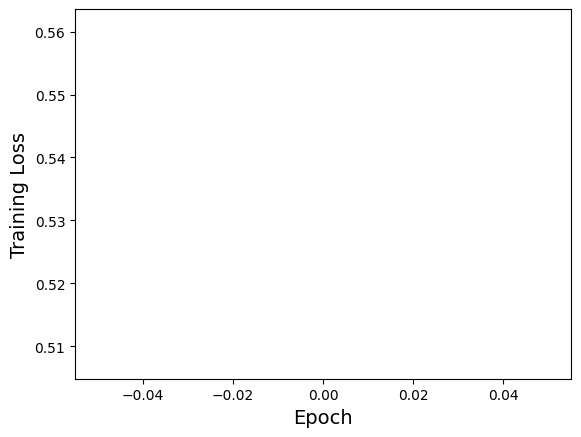

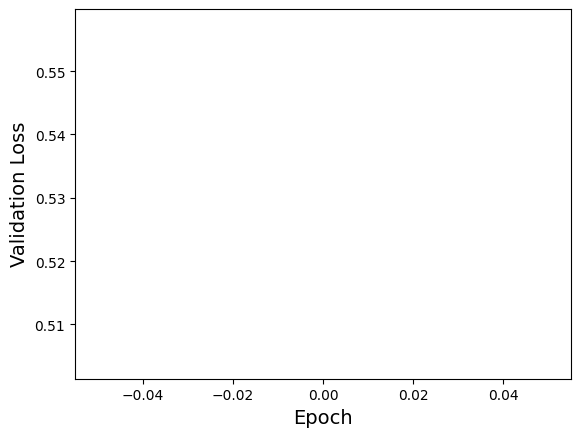

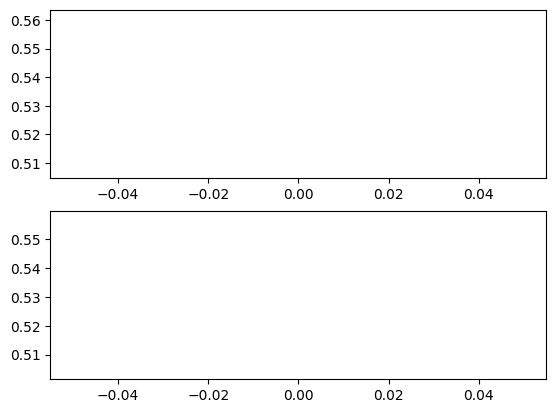

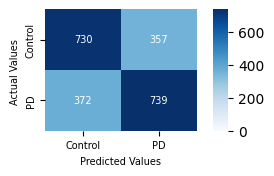

In [21]:
data_src =  '/Users/rakan/ResearchPD/DL_for_EEG/Data/UNM/all_data_reref_bandpass_1_to_45/'
EEG_whole_Dataset, _ = load_dataset(data_src=data_src)
input_tensor = torch.rand([8,60,2500]).to(device) #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
network = PD_CNN().to(device)
output_tensor = network(input_tensor)
print((output_tensor.shape))
#network = confirm_model(device=device)
trainloader, valloader = data_loader(EEG_whole_Dataset=EEG_whole_Dataset)
model, PATH = name_model(device=device)
model.train()
model, log_containing_train_loss, log_containing_val_loss = UNM_train(model=model,train_dataloader=trainloader, val_dataloader=valloader, epochs=1, learning_rate=0.0001, training_loss_tracker=[], val_loss_tracker=[], device=device)
torch.save(model, PATH)
# run_replicates(EEG_Dataset=EEG_whole_Dataset, device=device)
UNM_val(model=model, valloader=valloader)
UNM_visualize_1(log_containing_train_loss=log_containing_train_loss, log_containing_val_loss=log_containing_val_loss)
UNM_visualize_2(log_containing_train_loss=log_containing_train_loss, log_containing_val_loss=log_containing_val_loss)
plot_confusion_matrix(TP=739, FP=357, TN=730, FN=372)


## IU Testing Subject Level Experiment

torch.Size([8, 60, 2500])
torch.Size([8, 2])
 model has been successfully loaded
there are this many items in the list of data  304
there are this many items in the list of labels  304
The length of the lists of channels means and stds is  60
Performing testing on subject number:  CTL_1111
true positives:  0
false positives:  0
true negatives:  65
false negatives 0
The vote was:  Correct
65
-----------------------------------------------------------------------
total True Positives:  0
total False Positives:  0
total True Negatives:  65
total False Negatives:  0
total correct subject classifications:  1
total incorrect subject classifications:  0
total unsure subject classifications:  0
total subject level True positives:  0
total subject level False Positives:  0
total subject level True Negatives:  1
total subject level False Negatives:  0
total subject accuracy:  1.0
total subject F1:  0
total subject sensitivity:  0
total subject specificity:  1.0
----------------------------------

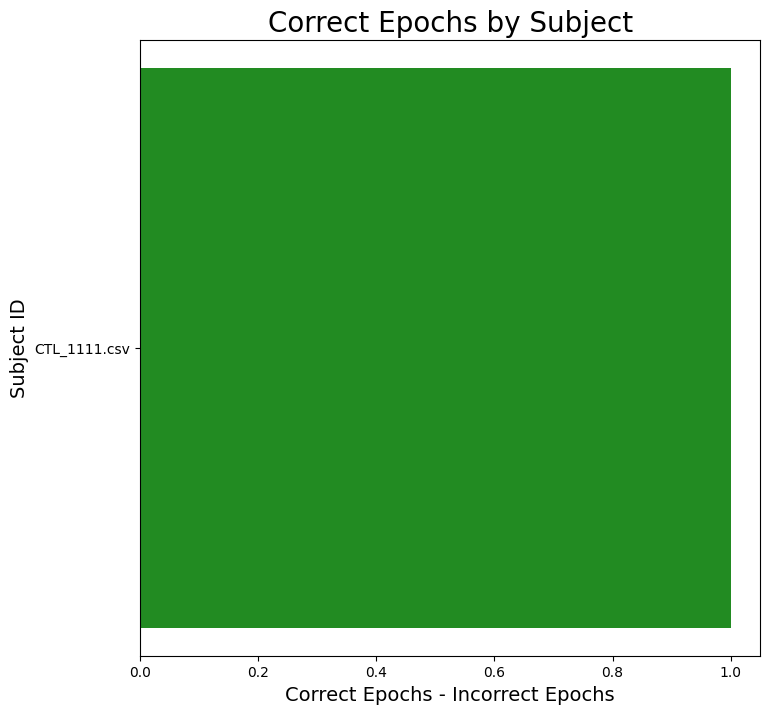

model was not found
new model has been successfully created
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0
total subject specificity:  0.0
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0
total subject specificity:  0.0
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0
total subject specificity:  0.0
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0
total subject specificity:  0.0
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0
total subject specificity:  0.0
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0
total subject specificity:  0.0
----------------------------------------

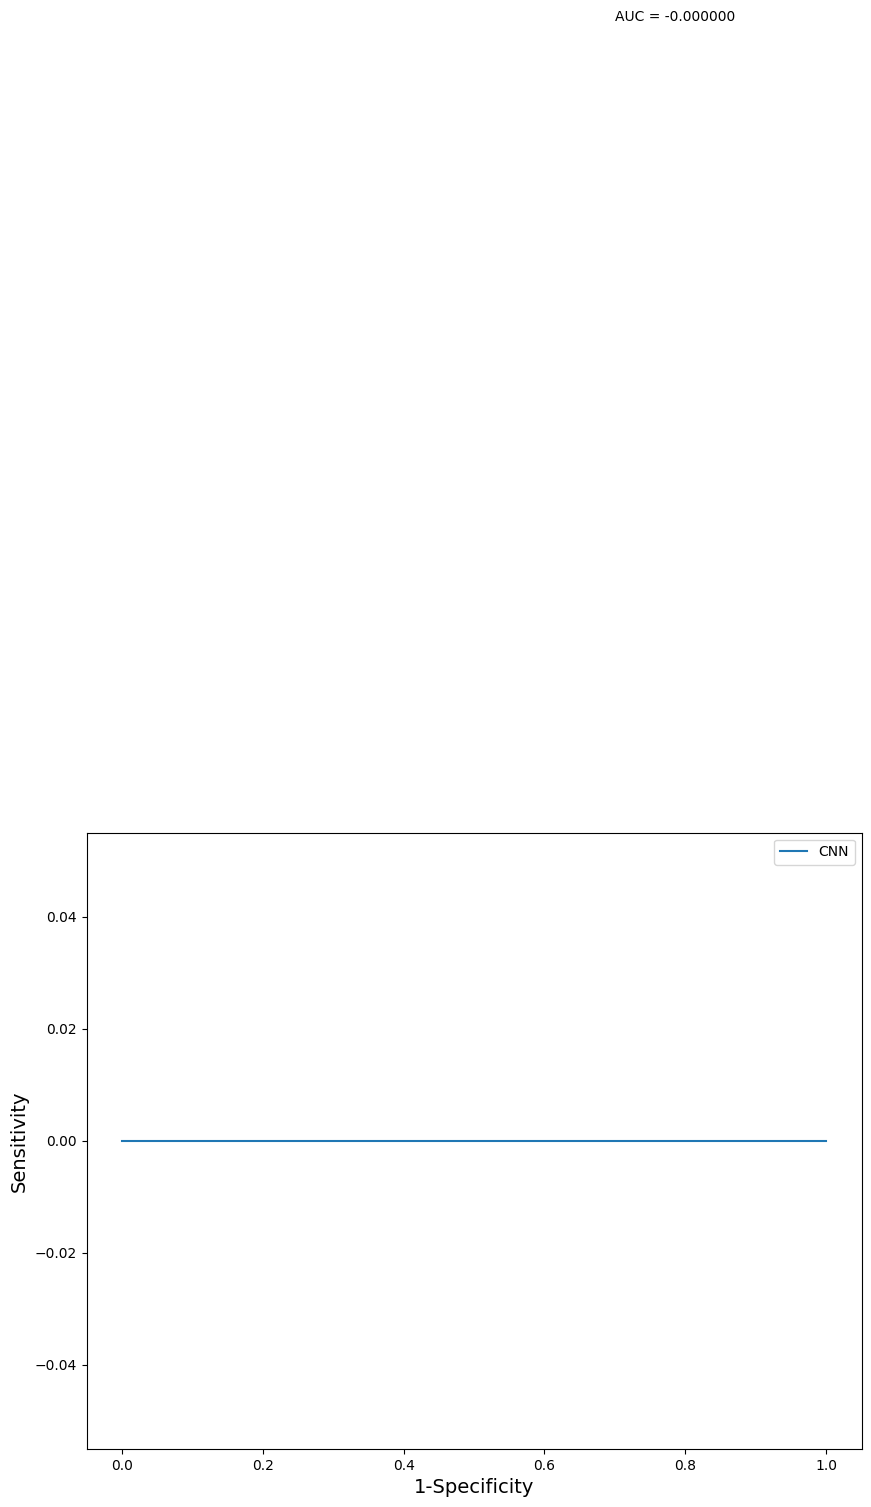

ValueError: At least 2 points are needed to compute area under curve, but x.shape = 0

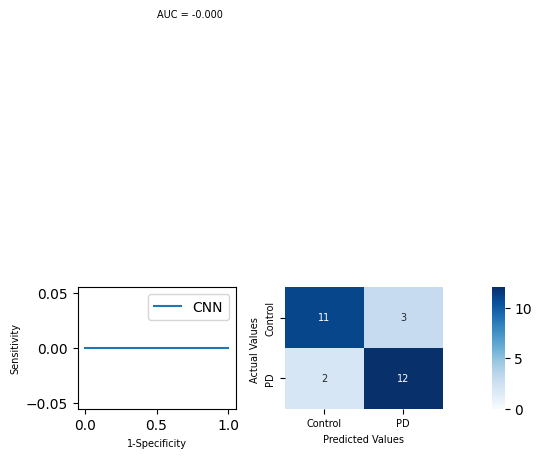

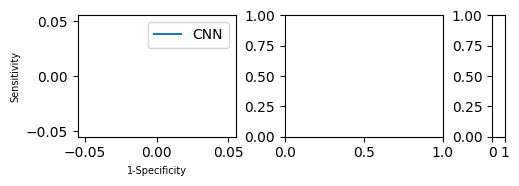

In [25]:
# model = confirm_model(device=device)
input_tensor = torch.rand([8,60,2500]).to(device) #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
network = PD_CNN().to(device)
output_tensor = network(input_tensor)
print((output_tensor.shape))
model, PATH = name_model(device=device)
#model = torch.load( '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')
#torch.save(model, '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')
subject_list, filename_list = subject_list()
data_src =  '/Users/rakan/ResearchPD/DL_for_EEG/Data/UI/all_data_reref_bandpass_1_to_45/' 
EEG_whole_Dataset, _ = load_dataset(data_src=data_src)
correct_epochs_list, incorrect_epochs_list, list_of_sequences = UNM_testing_subject(model=model, filename_list=filename_list, EEG_whole_Dataset=EEG_whole_Dataset)
#Visualize
waterfall_plot(correct_epochs_list=correct_epochs_list, incorrect_epochs_list=incorrect_epochs_list, filename_list=filename_list)
subject_sensitvities, subject_specificities = wise_roc_curve(filename_list=filename_list, EEG_whole_Dataset=EEG_whole_Dataset, device=device)
sequence_plot(model, filename_list, data_src, chunk_size=2500)
plot_roc_auc(subject_specificities, subject_sensitvities)
plot_roc_matrix(TP=12, FP=3, TN=11, FN=2, sensitivities=subject_sensitvities, specificities=subject_specificities)
plot_roc_matrix(TP=12, FP=3, TN=11, FN=2, sensitivities=[], specificities=[])
make_combo_plot(list_of_sequences, filename_list)


## Testing Epoch Level Experiment

In [20]:
# park_net = confirm_model(device=device)
input_tensor = torch.rand([8,60,2500]).to(device) #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
park_net = PD_CNN().to(device)
output_tensor = park_net(input_tensor)
print((output_tensor.shape))
data_src =  '/Users/rakan/ResearchPD/DL_for_EEG/Data/UI/all_data_reref_bandpass_1_to_45/'
EEG_whole_Dataset = load_dataset(data_src=data_src)
valloader = data_loader_val_only(EEG_whole_Dataset=EEG_whole_Dataset)
#manual model loading model = torch.load( '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')
#manual model saving torch.save(model, '/Users/rakan/ResearchPD/DL_for_EEG/saved_models')
model, PATH = epoch_level_model(device=device)
sensitivities , specificities = testing_epoch_func(model=model, valloader=valloader, device=device)
plot_roc_auc(specificities=specificities, sensitivities=sensitivities)
plot_confusion_matrix(TP=384, FP=128, TN=398, FN=132)
testing_epoch_viz() # Visualize
plot_both(TP1=1060, FP1=56, TN1=947, FN1=69,TP2=739, FP2=357, TN2=730, FN2=372)
plot_roc_matrix(TP=401, FP=131, TN=395, FN=115, sensitivities=sensitivities, specificities=specificities)
plot_confusion_matrix(TP=384, FP=128, TN=398, FN=132)





torch.Size([8, 60, 2500])
torch.Size([8, 2])
there are this many items in the list of data  304
there are this many items in the list of labels  304


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
    close()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


The length of the lists of channels means and stds is  60
model was not found
new model has been successfully created
threshold:  0


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/rakan/ResearchPD/DL_for_EEG/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/rakan/ResearchPD/DL_for_EEG/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/Users/rakan/ResearchPD/DL_for_EEG/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/Users/rakan/ResearchPD/DL_for_EEG/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'data_handling.EEGDataset'>


## CV UNM With Leak

In [ ]:
network = confirm_model(device=device)
data_src =  '/Users/rakan/ResearchPD/DL_for_EEG/Data/UNM/all_data_reref_bandpass_1_to_45/'
EEG_Dataset = load_dataset(data_src=data_src)
model, valloader = train_test_split(EEG_Dataset=EEG_Dataset, device=device)
CV_leak_visualize()
#run validation
#model = ParkNetCNN().to(device)
model.eval()
with_leak_validate(model=model,valloader=valloader,threshold=0.5,batch_size=8)


#for threshold in [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]:
  #validate(model=model,valloader=valloader,threshold=threshold,batch_size=batch_size)
  #print('-------')
#display training loss as a result
training_loss = sns.lineplot(np.arange(0,len(log_containing_train_loss)), log_containing_train_loss) 
_ = training_loss.set_xlabel('Epoch')
_ = training_loss.set_ylabel('Training Loss')
plt.show()
validation_loss = sns.lineplot(np.arange(0,len(log_containing_val_loss)), log_containing_val_loss) 
_ = validation_loss.set_xlabel('Epoch')
_ = validation_loss.set_ylabel('Validation Loss')
plt.show()